In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import os

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("AAPL.csv", sep=',')
df.index = pd.to_datetime(df.Date)
df = df.iloc[:, 1:]
df = df.drop_duplicates()
df = df.dropna()
df = df.sort_index()
df = df.iloc[-2000:]
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-03-19,16.410713,16.463215,16.017857,16.231787,14.187840,526775200.0
2013-03-20,16.336430,16.343929,16.056786,16.145714,14.112605,308660800.0
2013-03-21,16.079287,16.356428,16.075001,16.168928,14.132895,383255600.0
2013-03-22,16.235001,16.503571,16.182501,16.496786,14.419469,395105200.0
2013-03-25,16.596071,16.783930,16.492144,16.556429,14.471601,501135600.0
...,...,...,...,...,...,...
2021-02-19,130.240005,130.710007,128.800003,129.869995,129.869995,87525900.0
2021-02-22,128.009995,129.720001,125.599998,126.000000,126.000000,103607600.0
2021-02-23,123.760002,126.709999,118.389999,125.860001,125.860001,157859100.0


In [4]:
train_size = 0.95
ranges_test = int(df[['Close']].shape[0]*train_size)

train = df[['Close']].iloc[:ranges_test]
test = df[['Close']].iloc[ranges_test:]

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[['Close']])

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
print(scaled_train[-5:])

[[0.7610138 ]
 [0.78175483]
 [0.77502171]
 [0.78833313]
 [0.79591756]]


In [155]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size=1, shuffle=True)

In [156]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation

import tensorflow as tf

In [157]:
model = Sequential()
model.add(LSTM(12,activation="relu",input_shape=(n_input,n_features)))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer="adam",loss="mse")

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 12)                672       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 13        
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [158]:
validation_gen = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=1)

In [159]:
%%time

model.fit_generator(generator, validation_data=validation_gen, epochs=10)

Epoch 1/10
1895/1895 [==============================] - 4s 2ms/step - loss: 0.0130 - val_loss: 8.6177e-04
Epoch 2/10
1895/1895 [==============================] - 3s 2ms/step - loss: 1.1463e-04 - val_loss: 0.0012
Epoch 3/10
1895/1895 [==============================] - 3s 2ms/step - loss: 1.3847e-04 - val_loss: 0.0014
Epoch 4/10
1895/1895 [==============================] - 3s 2ms/step - loss: 1.4115e-04 - val_loss: 7.0193e-04
Epoch 5/10
1895/1895 [==============================] - 3s 2ms/step - loss: 1.9657e-04 - val_loss: 8.1253e-04
Epoch 6/10
1895/1895 [==============================] - 3s 2ms/step - loss: 1.1221e-04 - val_loss: 6.5756e-04
Epoch 7/10
1895/1895 [==============================] - 3s 2ms/step - loss: 1.1247e-04 - val_loss: 0.0017
Epoch 8/10
1895/1895 [==============================] - 3s 2ms/step - loss: 1.1058e-04 - val_loss: 0.0011
Epoch 9/10
1895/1895 [==============================] - 3s 2ms/step - loss: 1.8841e-04 - val_loss: 0.0044
Epoch 10/10
1895/1895 [===========

<AxesSubplot:title={'center':'Эпоха мен жоғалту қисығының графигі'}>

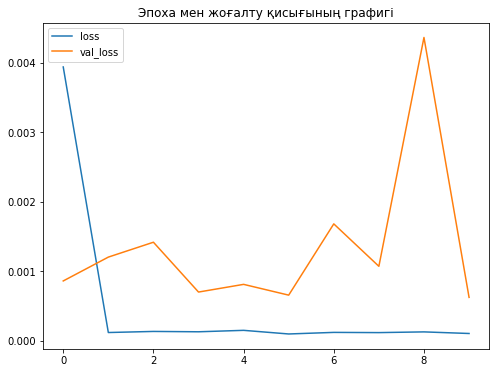

In [160]:
pd.DataFrame(model.history.history).plot(title="Жоғалту графигі")

In [161]:
days = 60

In [257]:
test_prediction = []
rander = 0
pred_info = scaled_train[-n_input:].reshape(1,n_input,n_features)

for i in range(len(test)-n_input):
    pred_info = model.predict(scaled_test[i:i+n_input].reshape(1,n_input,n_features))[0]
    test_prediction.append(pred_info)
    pred_info = np.append(pred_info[:,1:,:],[[pred_info]],axis=1)

for i in range(n_input + days):
    if i % 5 == 0:
        rander = ((np.random.rand(1)-0.5)/50)
    pred_info = model.predict(pred_info + rander)[0]
    test_prediction.append(pred_info)
    pred_info = np.append(pred_info[:,1:,:],[[pred_info]],axis=1)
    
test_prediction

[array([0.7851534], dtype=float32),
 array([0.7925627], dtype=float32),
 array([0.8161155], dtype=float32),
 array([0.82041407], dtype=float32),
 array([0.8265065], dtype=float32),
 array([0.83007646], dtype=float32),
 array([0.82715476], dtype=float32),
 array([0.81270325], dtype=float32),
 array([0.81027055], dtype=float32),
 array([0.8057252], dtype=float32),
 array([0.79890597], dtype=float32),
 array([0.79339623], dtype=float32),
 array([0.79168344], dtype=float32),
 array([0.79413664], dtype=float32),
 array([0.77894783], dtype=float32),
 array([0.7834481], dtype=float32),
 array([0.76678693], dtype=float32),
 array([0.7560514], dtype=float32),
 array([0.7542889], dtype=float32),
 array([0.76805735], dtype=float32),
 array([0.7842461], dtype=float32),
 array([0.7950679], dtype=float32),
 array([0.79743516], dtype=float32),
 array([0.79961324], dtype=float32),
 array([0.8099263], dtype=float32),
 array([0.8114439], dtype=float32),
 array([0.81294525], dtype=float32),
 array([0.818

In [258]:
true_prediction = scaler.inverse_transform(test_prediction)
true_prediction[:,0]

array([115.39913541, 116.35651404, 119.39982712, 119.95525583,
       120.74247385, 121.2037574 , 120.82623717, 118.95892218,
       118.64458641, 118.05727281, 117.17614067, 116.46421413,
       116.24289907, 116.55988421, 114.59729963, 115.17879077,
       113.02595964, 111.63879728, 111.41105904, 113.19011294,
       115.28190066, 116.68021503, 116.98609438, 117.26752863,
       118.60010159, 118.79620139, 118.99019094, 119.75464284,
       119.89898746, 119.34315827, 119.33032729, 118.75257916,
       116.95833757, 116.51054734, 116.55828227, 116.60279789,
       117.60493859, 119.7678281 , 121.04163734, 121.9330281 ,
       122.39206276, 123.26942108, 123.68812982, 122.88444563,
       123.23331567, 123.00379064, 122.57300569, 124.53126194,
       125.54296811, 126.60684536, 126.72047573, 127.7427948 ,
       129.08849139, 129.51923013, 130.26319561, 132.49298177,
       133.25310534, 133.33123103, 133.21435056, 131.86313958,
       131.40581468, 129.19361912, 129.78758696, 130.12

In [259]:
time_series_array = test.index
for k in range(0, days):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))
time_series_array

DatetimeIndex(['2020-10-02', '2020-10-05', '2020-10-06', '2020-10-07',
               '2020-10-08', '2020-10-09', '2020-10-12', '2020-10-13',
               '2020-10-14', '2020-10-15',
               ...
               '2021-04-17', '2021-04-18', '2021-04-19', '2021-04-20',
               '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24',
               '2021-04-25', '2021-04-26'],
              dtype='datetime64[ns]', name='Date', length=160, freq=None)

In [260]:
prediction_df = pd.DataFrame(columns=["Close", "predicted"], index=time_series_array)
prediction_df.loc[:,"predicted"] = true_prediction[:,0]
prediction_df.iloc[:train["Close"].shape[0],0] = test["Close"]
prediction_df

,Close,predicted
Date,,
2020-10-02,NaN,NaN
2020-10-05,NaN,NaN
2020-10-06,NaN,NaN
2020-10-07,NaN,NaN
2020-10-08,NaN,NaN
...,...,...
2021-04-22,NaN,NaN
2021-04-23,NaN,NaN
2021-04-24,NaN,NaN


<AxesSubplot:title={'center':'pred'}, xlabel='Date'>

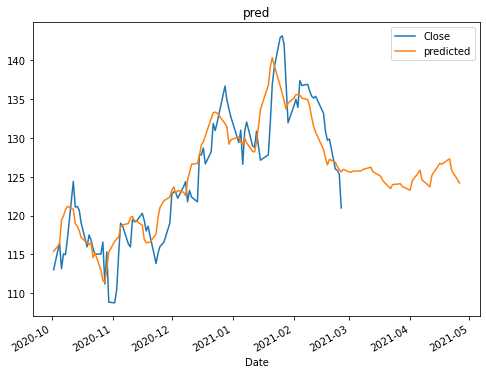

In [262]:
prediction_df.plot(title="pred")

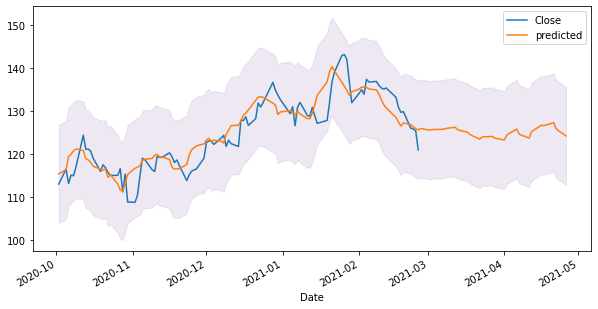

In [264]:
sum_errs = np.sum((np.array(prediction_df["Close"][:5]) - np.array(prediction_df["predicted"][:5]))**2)
stdev = np.sqrt(1/(5-2) * sum_errs)
interval = 1.96 * stdev

fig= plt.figure(figsize=(10,5))
df_forecast["Close"].plot()
df_forecast["predicted"].plot()
plt.fill_between(df_forecast.index, prediction_df["predicted"] - interval, prediction_df["predicted"] + interval, color="indigo",alpha=0.09,label="")
plt.legend()
plt.show()